In [605]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.6f}'.format  

# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


In [606]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [607]:
df=pd.read_csv('./datasets/원본data.csv',index_col=0)
df=df.drop(['원위안', '유가', '은', '외환보유액'],axis=1) # G7 이미 삭제된 데이터셋
dataset=df[['재고순환지표','경제심리지수','수출입물가비율','코스피','장단기','원달러','CD','G20','종가']].values
scaler=StandardScaler()
dataset= scaler.fit_transform(dataset)
print(dataset)

[[ 0.93589755  1.43327182  1.72403372 ...  2.89919104  1.24146097
  -1.49457805]
 [ 0.80523213  1.42294476  1.50708726 ...  2.58109256  1.06202031
  -1.75012721]
 [ 0.7220814   1.26803893  1.27464463 ...  2.33833319  0.85593723
  -1.81061445]
 ...
 [-1.58238152 -0.73540982 -1.45268221 ...  1.0157132  -0.42983655
  -0.3938106 ]
 [-1.61801754 -0.73540982 -1.48367456 ...  1.03245522 -0.39249759
  -0.27075728]
 [-1.66553224 -0.61148516 -1.49917074 ...  1.0157132  -0.35695238
  -0.27316174]]


In [608]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)



In [609]:
past_history = 2
future_target = 1
STEP = 1

X_train, y_train = multivariate_data(dataset, dataset[:, -1], 0, 148, past_history,
                                                   future_target, STEP, single_step=False)
X_test, y_test = multivariate_data(dataset, dataset[:, -1], 148, None, past_history,
                                               future_target, STEP, single_step=False)

print('Single window of past history : {}'.format(X_train[0].shape))

Single window of past history : (2, 9)


Epoch 1/30
5/5 [==============================] - 6s 166ms/step - loss: 1.1326 - val_loss: 0.3090
Epoch 2/30
5/5 [==============================] - 0s 57ms/step - loss: 1.1323 - val_loss: 0.3089
Epoch 3/30
5/5 [==============================] - 0s 59ms/step - loss: 1.1319 - val_loss: 0.3088
Epoch 4/30
5/5 [==============================] - 0s 58ms/step - loss: 1.1307 - val_loss: 0.3084
Epoch 5/30
5/5 [==============================] - 0s 60ms/step - loss: 1.1232 - val_loss: 0.3073
Epoch 6/30
5/5 [==============================] - 0s 65ms/step - loss: 1.0970 - val_loss: 0.3032
Epoch 7/30
5/5 [==============================] - 0s 59ms/step - loss: 0.9938 - val_loss: 0.2881
Epoch 8/30
5/5 [==============================] - 0s 60ms/step - loss: 0.8861 - val_loss: 0.2679
Epoch 9/30
5/5 [==============================] - 0s 59ms/step - loss: 0.7968 - val_loss: 0.2554
Epoch 10/30
5/5 [==============================] - 0s 60ms/step - loss: 0.6801 - val_loss: 0.2427
Epoch 11/30
5/5 [===========

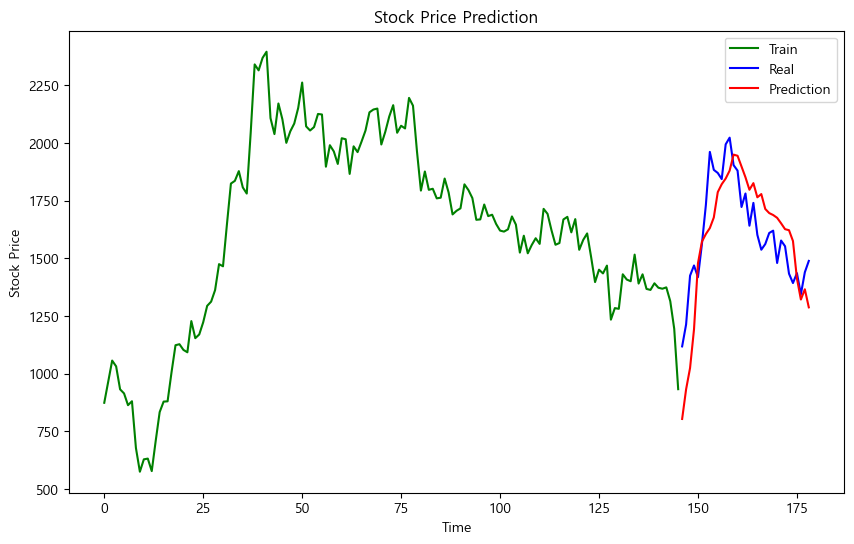

In [610]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import get_custom_objects

def prelu_activation(x):
    alpha = tf.constant(0.1)  # P-ReLU 매개변수
    return tf.keras.activations.relu(x) - alpha * tf.keras.activations.relu(-x)

get_custom_objects().update({'prelu_activation': prelu_activation})


def e_relu_activation(x):
    alpha = tf.constant(1.0)  # e-ReLU 매개변수
    return tf.keras.activations.relu(x) - alpha * (tf.exp(x) - 1)

get_custom_objects().update({'e_relu_activation': e_relu_activation})


# LSTM 모델 생성
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.22,recurrent_dropout =0.2,activation='e_relu_activation'))
model.add(LSTM(128, return_sequences=True, dropout=0.22, recurrent_dropout=0.2,activation='tanh'))
model.add(LSTM(64, dropout=0.22, recurrent_dropout=0.2,activation='e_relu_activation'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
history=model.fit(X_train, y_train,validation_data=(X_test,y_test), epochs=30, batch_size=30, verbose=1)

# 예측
train_predict = model.predict(X_train)
val_predict = model.predict(X_test)

scaler_y = StandardScaler()
scaled_data_y = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1,1))
# 예측 값 스케일 역변환
train_predict = scaler_y.inverse_transform(train_predict)
val_predict = scaler_y.inverse_transform(val_predict)

# 실제 값 스케일 역변환
y_train = scaler_y.inverse_transform(y_train.reshape(-1,1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1,1))


import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
# Add the training set to the plot:
plt.plot(y_train, color='green', label='Train')
# Plot the test and prediction data:
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(y_train), len(y_train)+len(y_test)), val_predict, color='red', label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
